#Ordinary Least Squares

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


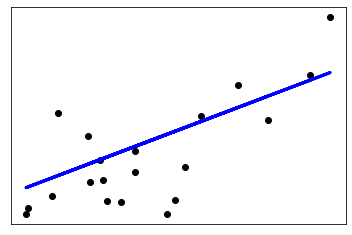

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.plot(diabetes_X_test, diabetes_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

#Ridge regression and classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
X = 1.0 / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

In [3]:
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

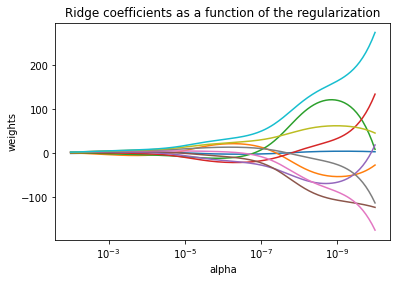

In [4]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

#Lasso

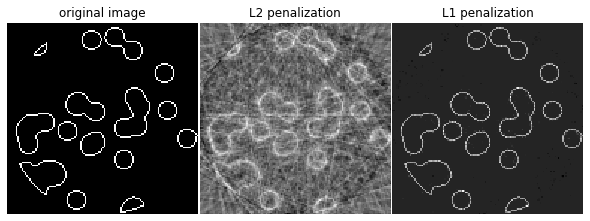

In [9]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()

#Multi-task Lasso

In [10]:
import numpy as np

rng = np.random.RandomState(42)

# Generate some 2D coefficients with sine waves with random frequency and phase
n_samples, n_features, n_tasks = 100, 30, 40
n_relevant_features = 5
coef = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)
for k in range(n_relevant_features):
    coef[:, k] = np.sin((1.0 + rng.randn(1)) * times + 3 * rng.randn(1))

X = rng.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + rng.randn(n_samples, n_tasks)

In [11]:
from sklearn.linear_model import MultiTaskLasso, Lasso

coef_lasso_ = np.array([Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.0).fit(X, Y).coef_

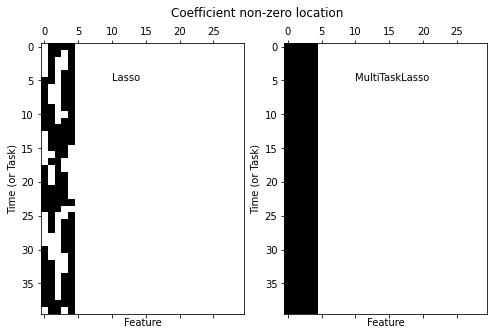

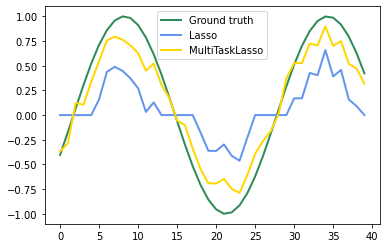

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.spy(coef_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "Lasso")
plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "MultiTaskLasso")
fig.suptitle("Coefficient non-zero location")

feature_to_plot = 0
plt.figure()
lw = 2
plt.plot(coef[:, feature_to_plot], color="seagreen", linewidth=lw, label="Ground truth")
plt.plot(
    coef_lasso_[:, feature_to_plot], color="cornflowerblue", linewidth=lw, label="Lasso"
)
plt.plot(
    coef_multi_task_lasso_[:, feature_to_plot],
    color="gold",
    linewidth=lw,
    label="MultiTaskLasso",
)
plt.legend(loc="upper center")
plt.axis("tight")
plt.ylim([-1.1, 1.1])
plt.show()

#Elastic-Net

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

np.random.seed(42)

n_samples, n_features = 50, 100
X = np.random.randn(n_samples, n_features)

# Decreasing coef w. alternated signs for visualization
idx = np.arange(n_features)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0  # sparsify coef
y = np.dot(X, coef)

# Add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[: n_samples // 2], y[: n_samples // 2]
X_test, y_test = X[n_samples // 2 :], y[n_samples // 2 :]

In [14]:
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1)
r^2 on test data : 0.658064


In [15]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.642515


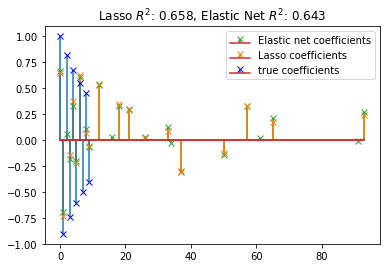

In [16]:
m, s, _ = plt.stem(
    np.where(enet.coef_)[0],
    enet.coef_[enet.coef_ != 0],
    markerfmt="x",
    label="Elastic net coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(
    np.where(lasso.coef_)[0],
    lasso.coef_[lasso.coef_ != 0],
    markerfmt="x",
    label="Lasso coefficients",
    use_line_collection=True,
)
plt.setp([m, s], color="#ff7f0e")
plt.stem(
    np.where(coef)[0],
    coef[coef != 0],
    label="true coefficients",
    markerfmt="bx",
    use_line_collection=True,
)

plt.legend(loc="best")
plt.title(
    "Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f" % (r2_score_lasso, r2_score_enet)
)
plt.show()

#LARS Lasso

Computing regularization path using the LARS ...
.

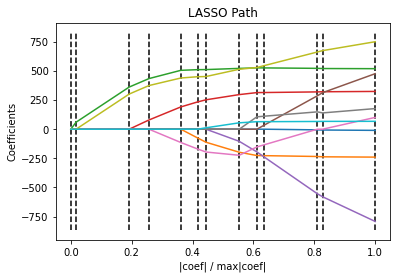

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets

X, y = datasets.load_diabetes(return_X_y=True)

print("Computing regularization path using the LARS ...")
_, _, coefs = linear_model.lars_path(X, y, method="lasso", verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.show()

#Bayesian Regression

In [19]:
import numpy as np


def func(x):
    return np.sin(2 * np.pi * x)


size = 25
rng = np.random.RandomState(1234)
x_train = rng.uniform(0.0, 1.0, size)
y_train = func(x_train) + rng.normal(scale=0.1, size=size)
x_test = np.linspace(0.0, 1.0, 100)

In [20]:
from sklearn.linear_model import BayesianRidge

n_order = 3
X_train = np.vander(x_train, n_order + 1, increasing=True)
X_test = np.vander(x_test, n_order + 1, increasing=True)
reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)

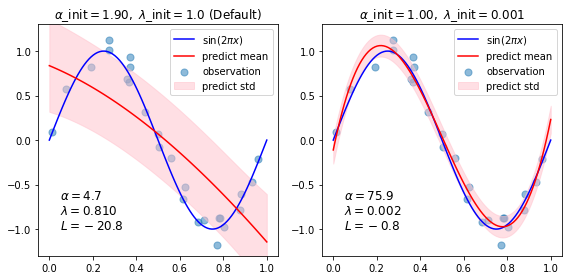

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for i, ax in enumerate(axes):
    # Bayesian ridge regression with different initial value pairs
    if i == 0:
        init = [1 / np.var(y_train), 1.0]  # Default values
    elif i == 1:
        init = [1.0, 1e-3]
        reg.set_params(alpha_init=init[0], lambda_init=init[1])
    reg.fit(X_train, y_train)
    ymean, ystd = reg.predict(X_test, return_std=True)

    ax.plot(x_test, func(x_test), color="blue", label="sin($2\\pi x$)")
    ax.scatter(x_train, y_train, s=50, alpha=0.5, label="observation")
    ax.plot(x_test, ymean, color="red", label="predict mean")
    ax.fill_between(
        x_test, ymean - ystd, ymean + ystd, color="pink", alpha=0.5, label="predict std"
    )
    ax.set_ylim(-1.3, 1.3)
    ax.legend()
    title = "$\\alpha$_init$={:.2f},\\ \\lambda$_init$={}$".format(init[0], init[1])
    if i == 0:
        title += " (Default)"
    ax.set_title(title, fontsize=12)
    text = "$\\alpha={:.1f}$\n$\\lambda={:.3f}$\n$L={:.1f}$".format(
        reg.alpha_, reg.lambda_, reg.scores_[-1]
    )
    ax.text(0.05, -1.0, text, fontsize=12)

plt.tight_layout()
plt.show()

#Logistic regression

C=1.00
Sparsity with L1 penalty:                6.25%
Sparsity with Elastic-Net penalty:       4.69%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.10
Sparsity with L1 penalty:                28.12%
Sparsity with Elastic-Net penalty:       14.06%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.01
Sparsity with L1 penalty:                84.38%
Sparsity with Elastic-Net penalty:       68.75%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.86
Score with Elastic-Net penalty:          0.88
Score with L2 penalty:                   0.89


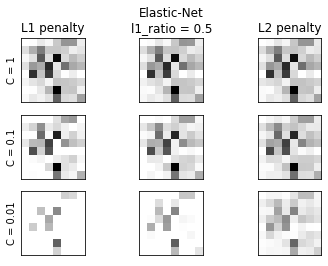

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X, y = datasets.load_digits(return_X_y=True)

X = StandardScaler().fit_transform(X)

# classify small against large digits
y = (y > 4).astype(int)

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(3, 3)

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty="l1", tol=0.01, solver="saga")
    clf_l2_LR = LogisticRegression(C=C, penalty="l2", tol=0.01, solver="saga")
    clf_en_LR = LogisticRegression(
        C=C, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01
    )
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:", sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:", clf_l1_LR.score(X, y)))
    print(
        "{:<40} {:.2f}".format("Score with Elastic-Net penalty:", clf_en_LR.score(X, y))
    )
    print("{:<40} {:.2f}".format("Score with L2 penalty:", clf_l2_LR.score(X, y)))

    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
        axes_row[2].set_title("L2 penalty")

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        ax.imshow(
            np.abs(coefs.reshape(8, 8)),
            interpolation="nearest",
            cmap="binary",
            vmax=1,
            vmin=0,
        )
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel("C = %s" % C)

plt.show()

#Generalized Linear Regression

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [48]:
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True).frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


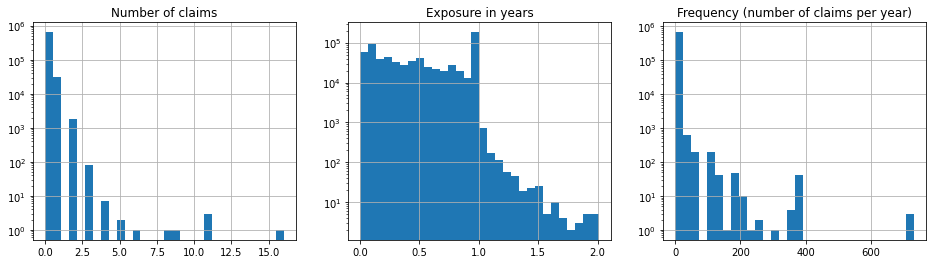

In [49]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

In [51]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


In [53]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [54]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.187
mean Poisson deviance: 0.599


In [55]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


Poisson Gradient Boosted Trees evaluation:
MSE: 0.558
MAE: 0.183
mean Poisson deviance: 0.574


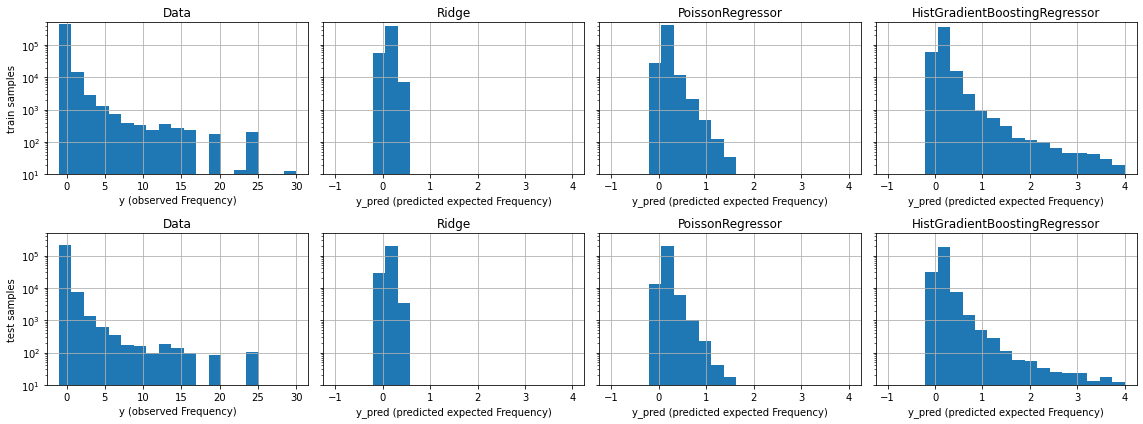

In [57]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        (
            "regressor",
            HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
)
poisson_gbrt.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

Actual number of claims: 11935.0
Predicted number of claims by Ridge(alpha=1e-06): 11940.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 11930.8
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 12073.7
Predicted number of claims by DummyRegressor(): 11931.2


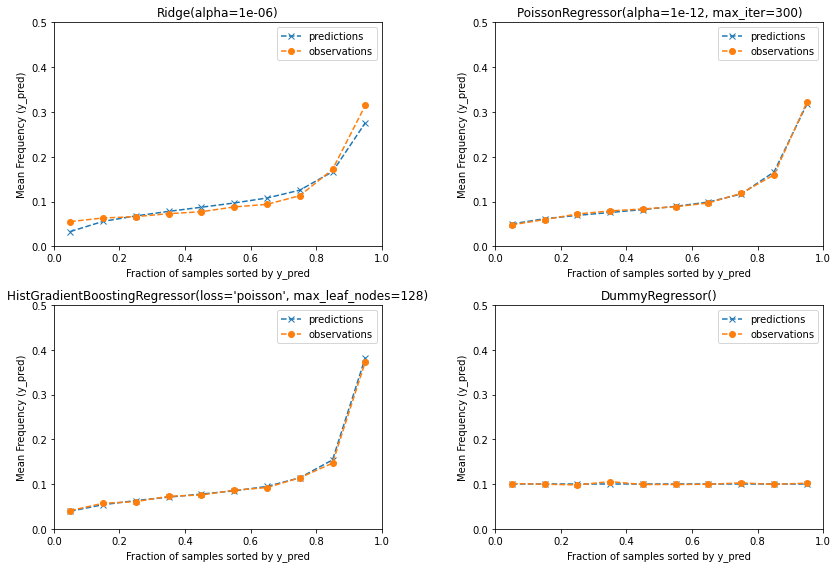

In [58]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

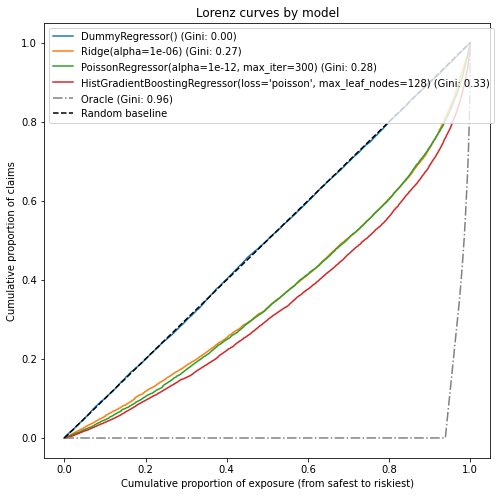

In [61]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims


fig, ax = plt.subplots(figsize=(8, 8))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)
ax.legend(loc="upper left")
plt.show()

#Stochastic Gradient Descent - SGD 

##Classification

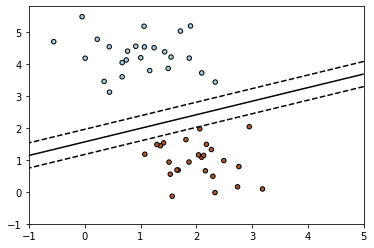

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_blobs

# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

##Stochastic Gradient Descent for sparse data

In [63]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:

        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

##Mathematical formulation

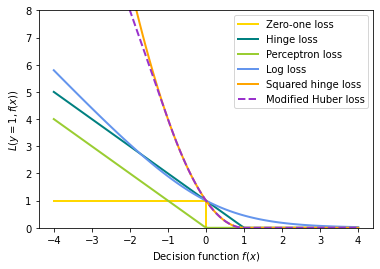

In [64]:
import numpy as np
import matplotlib.pyplot as plt


def modified_huber_loss(y_true, y_pred):
    z = y_pred * y_true
    loss = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.0] = 0
    return loss


xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color="gold", lw=lw, label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color="teal", lw=lw, label="Hinge loss")
plt.plot(xx, -np.minimum(xx, 0), color="yellowgreen", lw=lw, label="Perceptron loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color="cornflowerblue", lw=lw, label="Log loss")
plt.plot(
    xx,
    np.where(xx < 1, 1 - xx, 0) ** 2,
    color="orange",
    lw=lw,
    label="Squared hinge loss",
)
plt.plot(
    xx,
    modified_huber_loss(xx, 1),
    color="darkorchid",
    lw=lw,
    linestyle="--",
    label="Modified Huber loss",
)
plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$L(y=1, f(x))$")
plt.show()

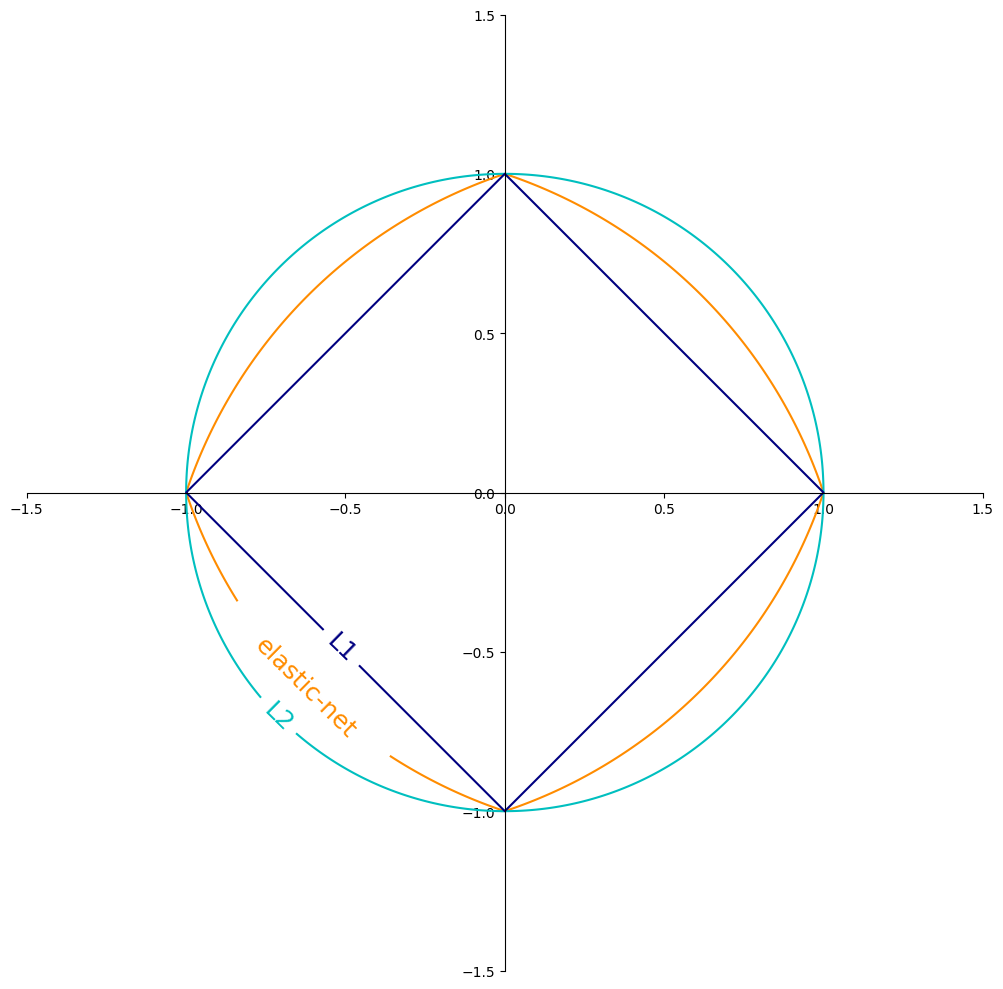

In [65]:
import numpy as np
import matplotlib.pyplot as plt

l1_color = "navy"
l2_color = "c"
elastic_net_color = "darkorange"

line = np.linspace(-1.5, 1.5, 1001)
xx, yy = np.meshgrid(line, line)

l2 = xx**2 + yy**2
l1 = np.abs(xx) + np.abs(yy)
rho = 0.5
elastic_net = rho * l1 + (1 - rho) * l2

plt.figure(figsize=(10, 10), dpi=100)
ax = plt.gca()

elastic_net_contour = plt.contour(
    xx, yy, elastic_net, levels=[1], colors=elastic_net_color
)
l2_contour = plt.contour(xx, yy, l2, levels=[1], colors=l2_color)
l1_contour = plt.contour(xx, yy, l1, levels=[1], colors=l1_color)
ax.set_aspect("equal")
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")

plt.clabel(
    elastic_net_contour,
    inline=1,
    fontsize=18,
    fmt={1.0: "elastic-net"},
    manual=[(-1, -1)],
)
plt.clabel(l2_contour, inline=1, fontsize=18, fmt={1.0: "L2"}, manual=[(-1, -1)])
plt.clabel(l1_contour, inline=1, fontsize=18, fmt={1.0: "L1"}, manual=[(-1, -1)])

plt.tight_layout()
plt.show()

#Robustness regression

In [66]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
]
colors = {"OLS": "turquoise", "Theil-Sen": "gold", "RANSAC": "lightgreen"}
lw = 2

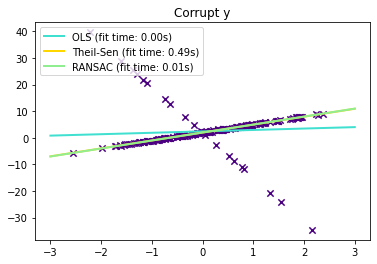

In [67]:
np.random.seed(0)
n_samples = 200
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
w = 3.0
c = 2.0
noise = 0.1 * np.random.randn(n_samples)
y = w * x + c + noise
# 10% outliers
y[-20:] += -20 * x[-20:]
X = x[:, np.newaxis]

plt.scatter(x, y, color="indigo", marker="x", s=40)
line_x = np.array([-3, 3])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )

plt.axis("tight")
plt.legend(loc="upper left")
_ = plt.title("Corrupt y")

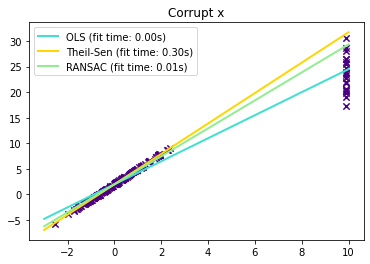

In [68]:
np.random.seed(0)
# Linear model y = 3*x + N(2, 0.1**2)
x = np.random.randn(n_samples)
noise = 0.1 * np.random.randn(n_samples)
y = 3 * x + 2 + noise
# 10% outliers
x[-20:] = 9.9
y[-20:] += 22
X = x[:, np.newaxis]

plt.figure()
plt.scatter(x, y, color="indigo", marker="x", s=40)

line_x = np.array([-3, 10])
for name, estimator in estimators:
    t0 = time.time()
    estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )

plt.axis("tight")
plt.legend(loc="upper left")
plt.title("Corrupt x")
plt.show()

#Quantile Regression

In [69]:
import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

In [70]:
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

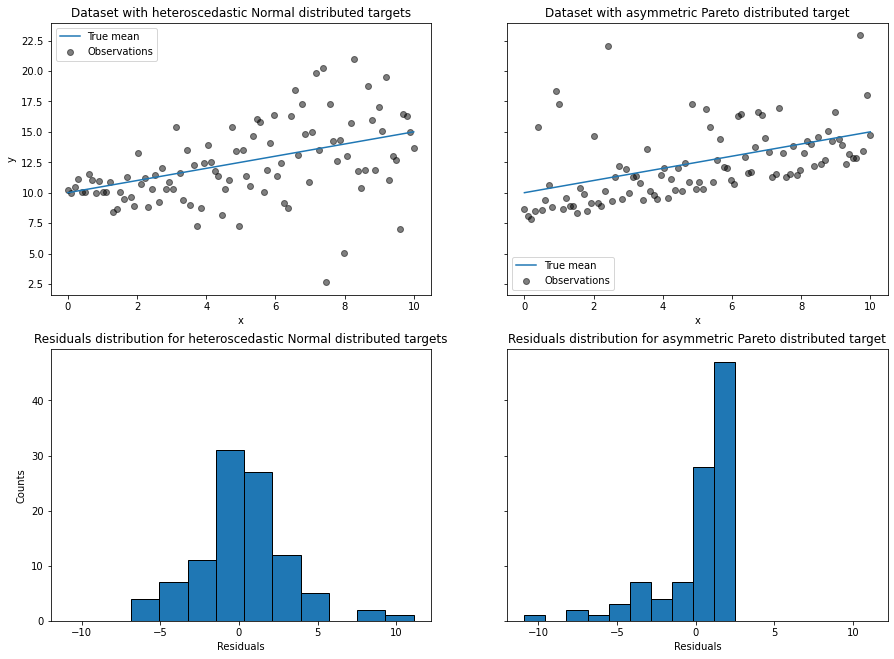

In [71]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")


axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

In [72]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

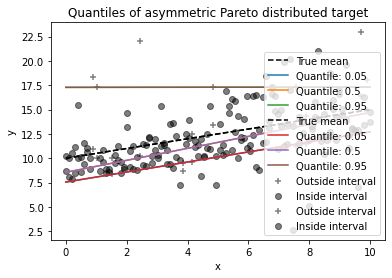

In [75]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    f"""Training error (in-sample performance)
    {linear_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_lr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_lr):.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {mean_absolute_error(y_pareto, y_pred_qr):.3f}
    MSE = {mean_squared_error(y_pareto, y_pred_qr):.3f}
    """
)

Training error (in-sample performance)
    LinearRegression:
    MAE = 1.805
    MSE = 6.486
    QuantileRegressor:
    MAE = 1.670
    MSE = 7.025
    


In [77]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    f"""Test error (cross-validated performance)
    {linear_regression.__class__.__name__}:
    MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.3f}
    {quantile_regression.__class__.__name__}:
    MAE = {-cv_results_qr["test_neg_mean_absolute_error"].mean():.3f}
    MSE = {-cv_results_qr["test_neg_mean_squared_error"].mean():.3f}
    """
)

Test error (cross-validated performance)
    LinearRegression:
    MAE = 1.732
    MSE = 6.690
    QuantileRegressor:
    MAE = 1.679
    MSE = 7.129
    


#Polynomial and Spline interpolation

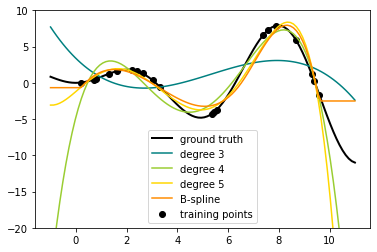

In [82]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)

x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False))
y_train = f(x_train)

# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(
    color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
)
ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

# plot training points
ax.scatter(x_train, y_train, label="training points")

# polynomial features
for degree in [3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label=f"degree {degree}")

# B-spline with 4 + 3 - 1 = 6 basis functions
model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
model.fit(X_train, y_train)

y_plot = model.predict(X_plot)
ax.plot(x_plot, y_plot, label="B-spline")
ax.legend(loc="lower center")
ax.set_ylim(-20, 10)
plt.show()

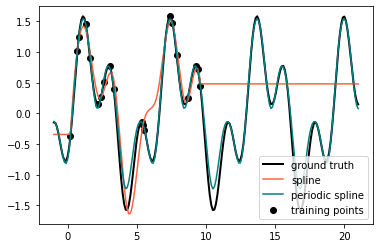

In [83]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)


y_train = g(x_train)

# Extend the test data into the future:
x_plot_ext = np.linspace(-1, 21, 200)
X_plot_ext = x_plot_ext[:, np.newaxis]

lw = 2
fig, ax = plt.subplots()
ax.set_prop_cycle(color=["black", "tomato", "teal"])
ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
ax.scatter(x_train, y_train, label="training points")

for transformer, label in [
    (SplineTransformer(degree=3, n_knots=10), "spline"),
    (
        SplineTransformer(
            degree=3,
            knots=np.linspace(0, 2 * np.pi, 10)[:, None],
            extrapolation="periodic",
        ),
        "periodic spline",
    ),
]:
    model = make_pipeline(transformer, Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_plot_ext = model.predict(X_plot_ext)
    ax.plot(x_plot_ext, y_plot_ext, label=label)

ax.legend()
fig.show()

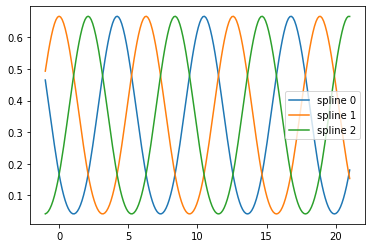

In [84]:
fig, ax = plt.subplots()
knots = np.linspace(0, 2 * np.pi, 4)
splt = SplineTransformer(knots=knots[:, None], degree=3, extrapolation="periodic").fit(
    X_train
)
ax.plot(x_plot_ext, splt.transform(X_plot_ext))
ax.legend(ax.lines, [f"spline {n}" for n in range(3)])
plt.show()